In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.datasets import load_breast_cancer
from sksurv.nonparametric import kaplan_meier_estimator

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

## Read Data

In [2]:
df = pd.read_csv('clinical-train.csv')
df.head()

,Num,Patient,surv_status,surv_time,DF_surv_status,DF_surv_time,DM_status,DM_time,IM_status,IM_time,...,clinical_44,clinical_45,clinical_46,clinical_47,clinical_48,clinical_49,clinical_50,clinical_51,clinical_52,clinical_53
0,1,SICK0000022,0,20.866667,0,11.233333,1,11.233333,0,20.866667,...,1,0,3,0,60.0,1,0,253,417,0.606715
1,2,SICK0000027,1,74.666667,0,31.600000,0,74.666667,0,74.666667,...,0,0,3,0,80.0,0,0,151,261,0.578544
2,3,SICK0000053,1,58.633333,1,58.633333,0,58.633333,0,58.633333,...,1,1,2,0,60.0,1,0,178,349,0.510029
3,4,SICK0000085,1,58.533333,1,58.533333,0,58.533333,0,58.533333,...,0,0,3,1,70.0,0,1,236,248,0.951613
4,5,SICK0000213,0,40.433333,0,13.766667,1,13.766667,1,13.766667,...,1,0,3,1,50.0,0,1,223,277,0.805054


In [3]:
df["surv_status"]=df["surv_status"].astype(bool)
df["surv_status"]

0      False
1       True
2       True
3       True
4      False
       ...  
278     True
279     True
280     True
281     True
282     True
Name: surv_status, Length: 283, dtype: bool

In [4]:
df["DF_surv_status"]=df["DF_surv_status"].astype(bool)
df["DF_surv_status"]

0      False
1      False
2       True
3       True
4      False
       ...  
278     True
279     True
280     True
281     True
282     True
Name: DF_surv_status, Length: 283, dtype: bool

In [5]:
data=df.iloc[0:, 2:4]
data1=df.iloc[0:, 4:6]
X=df.iloc[0:, 10:]

y=data.to_records(index=False)
y1=data1.to_records(index=False)
X=OneHotEncoder().fit_transform(X)

In [6]:
y.shape

(283,)

In [7]:
X

,clinical_01,clinical_02,clinical_03,clinical_04,clinical_05,clinical_06,clinical_07,clinical_08,clinical_09,clinical_10,...,clinical_44,clinical_45,clinical_46,clinical_47,clinical_48,clinical_49,clinical_50,clinical_51,clinical_52,clinical_53
0,1,45,2,1,1,2,1,2,0,1,...,1,0,3,0,60.0,1,0,253,417,0.606715
1,1,39,1,1,0,1,0,1,0,1,...,0,0,3,0,80.0,0,0,151,261,0.578544
2,1,41,2,1,0,2,3,2,1,1,...,1,1,2,0,60.0,1,0,178,349,0.510029
3,1,41,2,1,0,2,0,2,0,1,...,0,0,3,1,70.0,0,1,236,248,0.951613
4,1,40,1,1,0,1,0,1,0,1,...,1,0,3,1,50.0,0,1,223,277,0.805054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,1,42,2,1,0,2,0,2,0,1,...,1,0,3,0,70.0,0,0,252,509,0.495088
279,1,48,2,1,0,2,0,2,0,1,...,1,0,3,1,75.0,0,1,304,389,0.781491
280,2,65,3,1,1,2,1,2,0,1,...,1,0,3,2,30.0,1,0,185,301,0.614618
281,1,48,2,1,0,2,1,2,0,1,...,1,0,3,0,80.0,1,0,276,692,0.398844


In [8]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
print(X_std.shape)

X1 = pd.DataFrame(X_std)

(283, 51)


In [9]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_mms = mms.fit_transform(X)
print(X_mms.shape)

X2 = pd.DataFrame(X_mms)

(283, 51)


## surve time X1

In [10]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], "-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        #plt.text(
            #alpha_min, coef, name + "   ",
            #horizontalalignment="right",
            #verticalalignment="center"
        #)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

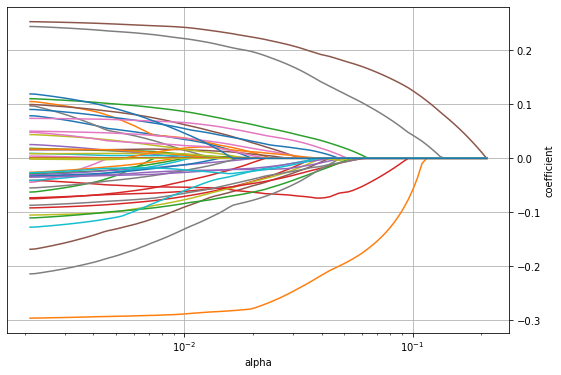

In [11]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(X1, y)

coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=X.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5)
plt.savefig('fig1.jpg', dpi=1200)
plt.show()

## surve time X2

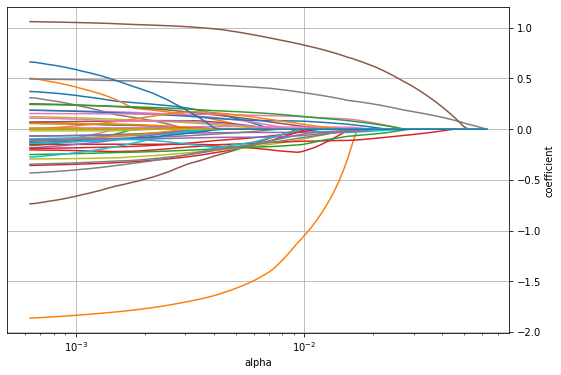

In [12]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(X2, y)

coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=X.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5)
plt.savefig('fig2.jpg', dpi=1200)
plt.show()

## surve time X1 & X2

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import FitFailedWarning


coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01, max_iter=100000)
)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(X1, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0))])

In [14]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1.0)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(X1, y)

cv_results = pd.DataFrame(gcv.cv_results_)

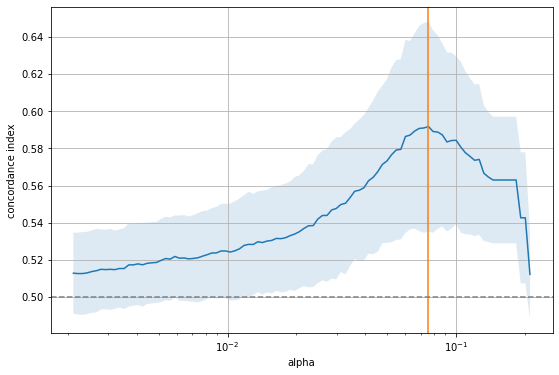

In [15]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

plt.savefig('fig3.jpg', dpi=1200)
plt.show()

Number of non-zero coefficients: 4


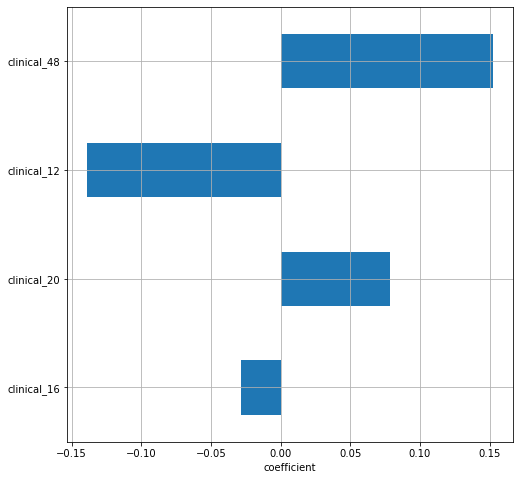

In [16]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=X.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(8, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

plt.savefig('fig4.jpg', dpi=1200)
plt.show()

In [17]:
non_zero_coefs

,coefficient
clinical_12,-0.138842
clinical_16,-0.028678
clinical_20,0.078265
clinical_48,0.152441


In [19]:
gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

CoxnetSurvivalAnalysis(alphas=[0.07583636856136143], l1_ratio=1.0)

## DF surve time

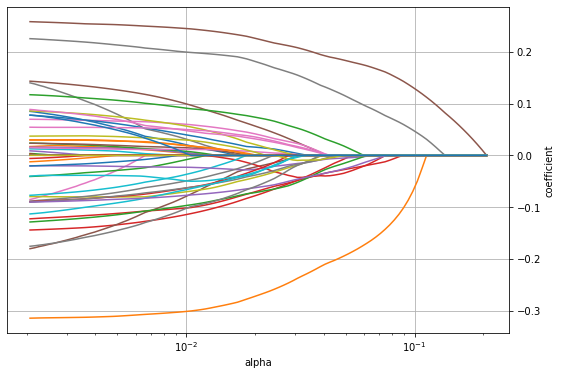

In [20]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(X1, y1)

coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=X.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5)
plt.savefig('fig_1.jpg', dpi=1200)
plt.show()

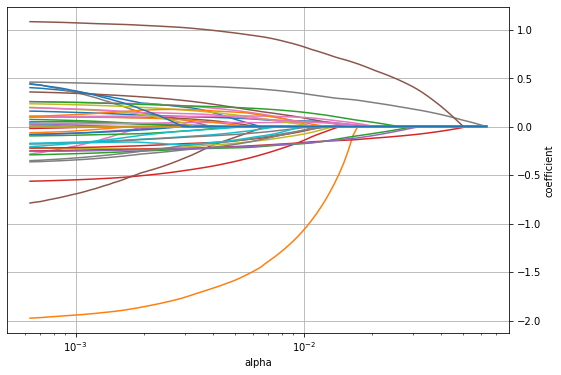

In [21]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(X2, y1)

coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=X.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5)
plt.savefig('fig_2.jpg', dpi=1200)
plt.show()

In [22]:
coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01, max_iter=100000)
)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(X1, y1)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0))])

In [23]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1.0)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(X1, y1)

cv_results = pd.DataFrame(gcv.cv_results_)

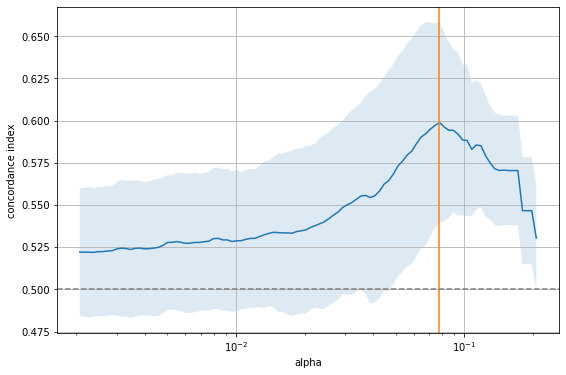

In [24]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

plt.savefig('fig_3.jpg', dpi=1200)
plt.show()

Number of non-zero coefficients: 4


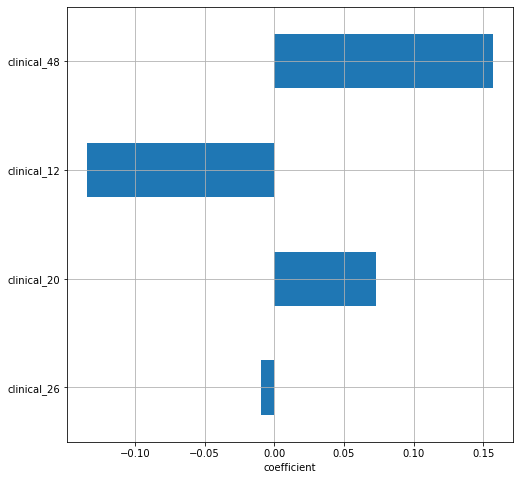

In [25]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=X.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(8, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

plt.savefig('fig_4.jpg', dpi=1200)
plt.show()

In [26]:
non_zero_coefs

,coefficient
clinical_12,-0.134233
clinical_20,0.072858
clinical_26,-0.009350
clinical_48,0.157052
